###  inicio

In [27]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

In [28]:
file_string = "./imagens/documentos/cursivo.png"
gmap = plt.cm.gray
line_dir = "./imagens/linhas/"
word_dir = "./imagens/palavras/"
if not os.path.exists(line_dir):
    os.mkdir(line_dir)
if not os.path.exists(word_dir):
    os.mkdir(word_dir)

### img

In [29]:
def initial(file:str):
    img = cv.imread(file)
    img_inverted = cv.bitwise_not(img)
    img_gs = cv.cvtColor(img_inverted, cv.COLOR_RGB2GRAY)
    _, img_otsu = cv.threshold(img_gs, 128, 255, cv.THRESH_OTSU)
    #https://matplotlib.org/stable/users/explain/colors/colormaps.html

    return img_otsu, img_otsu.shape[0], img_otsu.shape[1]

481 1914


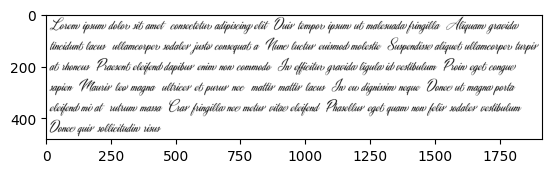

In [30]:
img, h, w = initial(file_string)
print(h, w)
plt.imshow(img, cmap = gmap)

#### outra estratégia

In [31]:
def fill_holes(img, size):
    h,w = img.shape
    new_img = np.zeros(shape=(h,w))
    
    count = 0

    for x in range(0,h):
        for y in range(0,w):
            if(x>0 and x<w-1 and y>1 and x<h-0):
                for i in range(-size, size+1):
                    for j in range(-size, size+1):
                        if(img[x+j][y+i] == 0):
                            count += 1
                if count < 9: 
                    new_img[x][y] = 255
                count = 0
    return new_img

### Declarando funções


In [32]:
def find_words(img):
    h,w = img.shape
    
    inicial = 0
    final = 0
    palavras = []
    empty_line_count = 0

    max_empty_lines = 4
    min_gap_size = 5


    for x in range(0, w):
        sum = 0
        for y in range(0,h):
            sum += img[y][x]
        col_avg = sum/h
        line_is_empty = col_avg == 255
        
        if line_is_empty:
                empty_line_count+=1

                if empty_line_count == max_empty_lines:
                    final = x
                    gap_size = final - inicial
                    
                    if gap_size > min_gap_size:
                        palavras.append(img[:, inicial:final])

                elif empty_line_count>4:
                    if col_avg == 255:
                        empty_line_count = 0
                    inicial = final
    return palavras


In [33]:
def skeletonize(img):
    clone = img.copy()
    h,w = img.shape

    temp_eroded = np.empty([h,w])
    temp_dilated = np.empty([h,w])
    temp_sub = np.empty([h,w])
    temp_out = np.empty([h,w])

    path = "./imagens/skeletization2/"

    kern = cv.getStructuringElement(cv.MORPH_ERODE, (3,3), (-1,-1))

    while cv.countNonZero(clone)!=0:

        temp_eroded = cv.erode(clone, kern)
        aux = cv.dilate(temp_eroded, kern)
        temp_dilated = cv.dilate(aux, kern)
        temp_sub = cv.subtract(clone, temp_dilated)
        temp_out = cv.bitwise_or(temp_sub.astype(np.uint8), temp_out.astype(np.uint8))
        clone = temp_eroded

        plt.imshow(temp_eroded, cmap=gmap)
        plt.savefig(f"{path}temp_eroded.png",format="png")
        
        plt.imshow(temp_dilated, cmap=gmap)
        plt.savefig(f"{path}temp_dilated.png",format="png")

        plt.imshow(temp_sub, cmap=gmap)
        plt.savefig(f"{path}temp_sub.png",format="png")

        plt.imshow(temp_out, cmap=gmap)
        plt.savefig(f"{path}temp_out.png",format="png")

        #final = cv.add(clone, final)
    return temp_out

In [34]:
def hor_density(img,h:int,w:int,min_h : int = 0,min_w : int = 0):
    most = 0
    least = 255
    avg_img = 0

    for y in range(min_h, h):
        sum = 0
        for x in range(min_w,w):
            sum += img[y][x]
        
        avg_line = sum/(w-min_w)
        avg_img += avg_line

        if avg_line > most:
            most = avg_line
        elif avg_line < least:
            least = avg_line
    
    avg_img = avg_img/(h-min_h)
    
    return avg_img, most, least

In [35]:
def ver_density(img,h:int,w:int,min_h : int = 0,min_w : int = 0):
    most = 0
    least = 255
    avg_img = 0

    for x in range(min_w, w):
        sum = 0
        for y in range(min_h, h):
            sum += img[y][x]
        
        avg_col = sum/(h-min_h)
        avg_img += avg_col

        if avg_col > most:
            most = avg_col
        elif avg_col < least:
            least = avg_col
    
    avg_img = avg_img/(w-min_w)
    
    return avg_img, most, least

In [36]:
def save_img(img, path):
    cv.imwrite(path, img)

### Esqueletização

C:\Users\priga\AppData\Local\Temp\ipykernel_7968\95622874.py:20: RuntimeWarning: invalid value encountered in cast
  temp_out = cv.bitwise_or(temp_sub.astype(np.uint8), temp_out.astype(np.uint8))


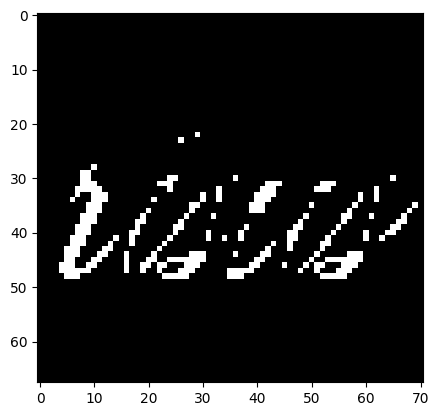

In [37]:
palavra = cv.imread("./imagens/palavras/-5-3.png")
img_inverted = cv.bitwise_not(palavra)
img_gs = cv.cvtColor(img_inverted, cv.COLOR_RGB2GRAY)
cv.imwrite("ultima_palavra_inv.png",img_gs)
_, palavra = cv.threshold(img_gs, 128, 255, cv.THRESH_OTSU)
skeli = skeletonize(palavra)

### Identificando o valor médio de uma área de texto intensa

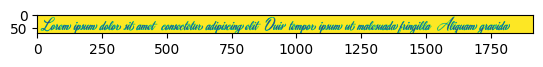

In [38]:
plt.imshow(img[0:70,])

In [39]:
hor_density(img, 80, w)
#0,80

(231.74157523510968, 255.0, 160.4075235109718)

### Identificando o valor médio em uma área vazia

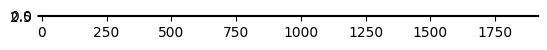

In [40]:
plt.imshow(img[71:75,])

In [41]:
hor_density(img, 75, w, 71)

(251.33620689655172, 251.8025078369906, 251.26959247648904)

### Selecionando Linha automaticamente

In [42]:
i=0
start = 0
end = 0
aux=[]

for y in range(0, h):
    sum = 0
    for x in range(0,w):
        sum += img[y][x]
    line_avg = sum/w
    if line_avg == 255:
        i+=1

        if i == 4:
            end = y

            if end - start > 15:
                n = aux.append(img[start:end, ])
                #print(start, end)

            start = end
        
        elif i>4:
            if line_avg == 255:
                i = 0
i=0        
for line in aux:
    cv.imwrite(f"{line_dir}{i}.png", line)
    i+=1
    


### Identificando valor médio da coluna com texto intenso

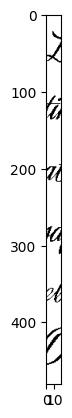

In [43]:
plt.imshow(img[:,20:40], cmap = plt.cm.gray)

In [44]:
ver_density(img, h, 40, min_w = 20)

(224.22505197505194, 232.2037422037422, 217.8898128898129)

### media coluna pouco texto


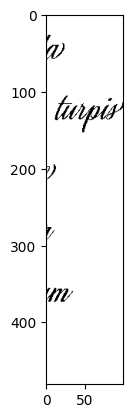

In [45]:
plt.imshow(img[:,1800:1900], cmap = plt.cm.gray)

In [46]:
ver_density(img,h,1900,min_w=1800)

(247.95436590436609, 254.46985446985448, 236.44490644490645)

In [47]:
maior = 0
menor = 255
media_img = 0
for x in range(50,70):
    sum = 0
    for y in range(0, h):
        sum += img[y][x]
    media_linha = sum/h
    media_img += media_linha
    if media_linha > maior:
        maior = media_linha
    if media_linha < menor:
        menor = media_linha
    print("{:.2f}".format(media_linha))#724
media_img = media_img/20
print(f"media {media_img} ||| maior {maior} ||| menor {menor}")

221.07
224.78
229.02
230.08
235.38
233.79
233.26
228.49
227.96
232.20
230.61
232.20
230.61
229.55
228.49
225.84
221.07
222.13
227.96
226.37
media 228.54573804573806 ||| maior 235.3846153846154 ||| menor 221.07068607068607


### Encontrando palavras automaticamente

In [48]:
for k in range(0,len(aux)):
    palavras = find_words(aux[k])
    i=0
    for word in palavras:
        cv.imwrite(f"{word_dir}-{k}-{i}.png", word)
        i+=1

### FILL HOLES

#### FALHAS

A tentativa a seguir deu ruim... O "flood_fill" não funciona como a gente gostaria.

In [49]:
def fill_holes(img):
    h, w = img.shape[:2]
    mask = np.zeros((5, 5), np.uint8)
    
    # Floodfill from point (0, 0)
    cv.floodFill(img, mask, (0,0), 255);
    return img

#### TENTATIVA ATUAL

In [50]:
def fill_holes(img):
    h,w = img.shape
    print(h,w)
    new_img = np.zeros(shape=(h,w))
    kernel = [[1,0,1,0,1],
              [0,1,1,1,0],
              [1,1,1,1,1],
              [0,1,1,1,0],
              [1,0,1,0,1]]
    count = 0

    for x in range(0,h):
        for y in range(0,w):
            if(x>3 and x<w-3 and y>3 and y<h-3):
                if img[y][x] == 255:
                    new_img[y][x] = 255
                
                elif img[y][x] == 0:
                    
                    for i in range(-2,2):
                        for j in range(-2,2):
                            if(img[y+j][x+i] == 255):
                                count += 1

                    if count > 2: 
                        new_img[y][x] = 255


                count = 0
    return new_img

68 71


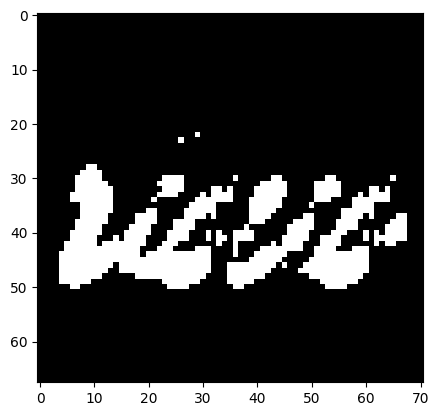

In [51]:
temp = fill_holes(skeli)
plt.imshow(temp, cmap=gmap)

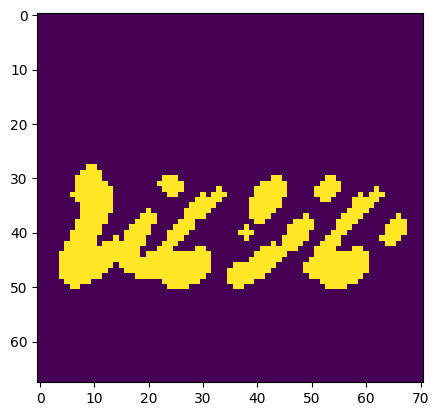

In [52]:
kern = cv.getStructuringElement(cv.MORPH_CROSS, (3,3), (-1,-1))

temp3 = cv.erode(temp, kern)
temp2 = cv.dilate(temp3, kern)

plt.imshow(temp2)